In [71]:
import pandas as pd
import numpy as np
import os
import sqlite3
import math
from constant_values import get_passing_stat_ids, get_rushing_stat_ids, get_receiving_stat_ids, get_general_stat_ids, id_2_col, operation_2_str, year_2_idx
from scipy import stats
from matplotlib import pyplot as plt
import csv
import time
from itertools import chain

In [4]:
# ==== Output Files =====
CURRENT_FILE_DIR = 'os.path.dirname(os.path.realpath(__file__))'
DATA_DIR = '../../data'
DATABASE_FILENAME = 'nfl_road_statistics.db'
DATABASE_PATH = os.path.join(DATA_DIR, 'raw', DATABASE_FILENAME)
conn = sqlite3.connect(DATABASE_PATH)
print('OPENED CONNECTION')

OPENED CONNECTION


In [5]:
# ==== Statistic Calculations =====
STAT_KEYS = ['home_mean', 'road_mean', 'home_std', 'road_std', 'home_count', 'road_count', 't_stat', 'p_val', 'difference', 'stat_type']
def _get_means(value_distribution):
	return [np.mean(value_distribution['home_values']), np.mean(value_distribution['road_values'])]

def _get_stds(value_distribution):
	return [np.std(value_distribution['home_values']), np.std(value_distribution['road_values'])]

def _get_2_sample_t_results(value_distribution):
	return stats.ttest_ind(value_distribution['home_values'], value_distribution['road_values'])

In [6]:
# ==== Query QB Statistics =====
def get_sql_statement(key_value_dict, data_type):
	table = 'passing_statistics'
	if data_type == 'rushing':
		table = 'rushing_statistics'
	elif data_type == 'receiving':
		table = 'receiving_statistics'

	statement = '''SELECT * FROM %s''' % table
	if len(key_value_dict) > 0:
		statement += ' WHERE'
		for key in key_value_dict:
			if type(key_value_dict[key]['value']) == str:
				statement += ' %s %s %s AND' % (key, str(key_value_dict[key]['operation']), "'" + str(key_value_dict[key]['value']) + "'")
			else:
				statement += ' %s %s %s AND' % (key, str(key_value_dict[key]['operation']), str(key_value_dict[key]['value']))
		statement = statement[:-4]

	return statement + ';'

In [7]:
def get_road_games(key_value_dict, data_type):
	key_value_dict['GAME_LOCATION'] = {
		'value': '@',
		'operation': '='
	}

	statement = get_sql_statement(key_value_dict, data_type)

	road_games = pd.read_sql_query(statement, conn)
	return road_games

In [8]:
def get_home_games(key_value_dict, data_type):
	key_value_dict['GAME_LOCATION'] = {
		'value': '',
		'operation': '='
	}
	statement = get_sql_statement(key_value_dict, data_type)

	home_games = pd.read_sql_query(statement, conn)
	return home_games

In [72]:
def get_value_distributions(road_qb_games, home_qb_games, statistic):
	return {
	'home_values': np.array(home_qb_games[statistic]),
	'road_values': np.array(road_qb_games[statistic])
	}

In [73]:
def map_nan_to_val(new_val, value_distribution):
	home_values = value_distribution['home_values']
	road_values = value_distribution['road_values']
	for i in range(len(home_values)):
		if str(home_values[i]) == 'nan':
			home_values[i] = new_val
	for i in range(len(road_values)):
		if str(road_values[i]) == 'nan':
			road_values[i] = new_val

In [81]:
def stat_id_list_2_col_list(stat_id_list):
    id2col = id_2_col()
    return list(map(lambda x: id2col[x], stat_id_list))

In [154]:
def get_t_stats(val_dist, stat_id):
    home_games_stat = val_dist['home_values']
    road_games_stat = val_dist['road_values']
    if type(home_games_stat[0]) == str:
        raise Exception('Stat is not numeric')
    home_mean = np.mean(home_games_stat)
    road_mean = np.mean(road_games_stat)
    home_std = np.std(home_games_stat)
    road_std = np.std(road_games_stat)
    pooled_std = math.sqrt(((len(home_games)-1)*home_std**2 + (len(road_games)-1)*road_std**2)/(len(home_games) + len(road_games) - 2))
    standard_error = math.sqrt(home_std**2/(len(home_games)-1) + road_std**2/(len(road_games)-1))
    t_stat, p_val = stats.ttest_ind(home_games_stat, road_games_stat)
    cohen = (home_mean - road_mean)/pooled_std
    my_t = (home_mean - road_mean)/standard_error
    return t_stat, p_val, cohen, my_t

In [148]:
def get_value_distribution_stats(value_distribution, stat_id):
	value_dist_copy = value_distribution.copy()
	map_nan_to_val(0, value_dist_copy)

	t_stat, pval, cohen, my_t = get_t_stats(value_dist_copy, stat_id)

	if stat_id in get_passing_stat_ids() or stat_id in stat_id_list_2_col_list(get_passing_stat_ids()):
		stat_type = 'passing'
	elif stat_id in get_rushing_stat_ids() or stat_id in stat_id_list_2_col_list(get_rushing_stat_ids()):
		stat_type = 'rushing'
	elif stat_id in get_receiving_stat_ids() or stat_id in stat_id_list_2_col_list(get_receiving_stat_ids()):
		stat_type = 'receiving'
	else:
		raise Exception('Invalid Stat: ' + stat_id)

	return {
	'home_mean': _get_means(value_dist_copy)[0],
	'road_mean': _get_means(value_dist_copy)[1],
	'home_std': _get_stds(value_dist_copy)[0],
	'road_std': _get_stds(value_dist_copy)[1],
	'home_count': len(value_dist_copy['home_values']),
	'road_count': len(value_dist_copy['road_values']),
	't_stat': t_stat,
	'p_val': pval,
    'cohen': cohen,
    'my_t': my_t,
	'difference': _get_means(value_dist_copy)[0] - _get_means(value_dist_copy)[1],
	'stat_type': stat_type
	}

In [12]:
def display_distributions(value_distribution, stat_id):
	home_values = value_distribution['home_values']
	road_values = value_distribution['road_values']
	plt.hist(home_values, alpha=0.5, label='Home')
	plt.hist(road_values, alpha=0.5, label='Road')
	plt.title(stat_id)
	plt.legend(loc='upper right')
	plt.show()

In [13]:
# ==== Write Results =====
def write_query_info_to_csv(csv_writer, key_value_dict):
	for k in key_value_dict:
		csv_writer.writerow([k, key_value_dict[k]['operation'], key_value_dict[k]['value']])
	header_row = ['stat_id']
	header_row.extend(STAT_KEYS)
	csv_writer.writerow([])
	csv_writer.writerow(header_row)

In [14]:
def write_stat_to_csv(stat_vals, stat_id, csv_writer):
	print(stat_id)
	stat_row = [stat_vals[key] for key in STAT_KEYS]
	stat_row.insert(0, stat_id)
	csv_writer.writerow(stat_row)

In [15]:
# ==== Organize Inputs =====
# CHANGE HERE
AUTOMATICALLY_OVERWRITE = True
DATA_TYPE = 'receiving'

In [16]:
def get_key_value_dict_list():
	if DATA_TYPE == 'receiving':
		l = [
				{
					'YEAR': {
						'value': 2008,
						'operation': '>='
					}
				}
			]
		for i in range(2008, 2019):
			l.append({
						'YEAR': {
							'value': i,
							'operation': '='
						}
					})
	elif DATA_TYPE == 'passing':
		l = [
				{
					'YEAR': {
						'value': 2008,
						'operation': '>='
					},
					'PASS_ATTEMPTS': {
						'value': 10,
						'operation': '>='
					}
				}
			]
		for i in range(2008, 2019):
			l.append({
						'YEAR': {
							'value': i,
							'operation': '='
						},
						'PASS_ATTEMPTS': {
							'value': 10,
							'operation': '>='
						}
					})
	elif DATA_TYPE == 'rushing':
		l = [
				{
					'YEAR': {
						'value': 2008,
						'operation': '>='
					},
					'RUSH_ATTEMPTS': {
						'value': 5,
						'operation': '>='
					}
				}
			]
		for i in range(2008, 2019):
			l.append({
						'YEAR': {
							'value': i,
							'operation': '='
						},
						'RUSH_ATTEMPTS': {
							'value': 5,
							'operation': '>='
						}
					})
	else:
		raise Excpetion('Bad DATA_TYPE')
	return l

In [17]:
def get_filename(key_value_dict):
	type_file_dir = os.path.join(DATA_DIR, 'interim', DATA_TYPE)
	filename = DATA_TYPE + '_'
	for key in key_value_dict:
		filename += key + '_'
		filename += operation_2_str()[key_value_dict[key]['operation']] + '_' + str(key_value_dict[key]['value']) + '_'
	return os.path.join(type_file_dir, filename[:-1] + '.csv')

In [18]:
def get_stat_ids():
	if DATA_TYPE == 'passing':
		return get_passing_stat_ids()
	elif DATA_TYPE == 'rushing':
		return get_rushing_stat_ids()
	elif DATA_TYPE == 'receiving':
		return get_receiving_stat_ids()
	raise Exception('Data Type Incorrect')
	return None

In [19]:
def get_query_stats(kvd, data_type):
	road_games = get_road_games(kvd.copy(), data_type)
	home_games = get_home_games(kvd.copy(), data_type)
	return road_games, home_games

In [20]:
def write_all_aggregated_stats():
	global DATA_TYPE
	for dt in ['passing', 'rushing', 'receiving']:
		DATA_TYPE = dt
		for kvd in get_key_value_dict_list():
			output_file = get_filename(kvd)
			if os.path.isfile(output_file) and not AUTOMATICALLY_OVERWRITE:
				raise Exception('File already exists')
			road_qb_games, home_games = get_query_stats(kvd.copy(), DATA_TYPE)
			stat_id_2_sql = id_2_col()
			csv_file = open(output_file, 'w')
			csv_writer = csv.writer(csv_file)
			write_query_info_to_csv(csv_writer, kvd.copy())
			stat_id_list = get_stat_ids()
			for stat_id in stat_id_list:
				value_distribution = get_value_distributions(road_qb_games, home_qb_games, stat_id_2_sql[stat_id])
				if type(value_distribution['home_values'][0]) == str:
					continue
				stat_vals = get_value_distribution_stats(value_distribution, stat_id)
				write_stat_to_csv(stat_vals, stat_id, csv_writer)

			csv_writer.writerow([])
			csv_writer.writerow([])
			csv_file.close()

In [21]:
# ==== Temporal Functions =====

def get_all_temporal_stats():
	temporal_dict = {}
	global DATA_TYPE
	for dt in ['passing', 'rushing', 'receiving']:
		DATA_TYPE = dt
		for kvd in get_key_value_dict_list():
			year_val = kvd['YEAR']['value']
			if kvd['YEAR']['operation'] != '=':
				year_val = 'all'
			road_qb_games = get_road_games(kvd.copy(), DATA_TYPE)
			home_qb_games = get_home_games(kvd.copy(), DATA_TYPE)
			stat_id_2_sql = id_2_col()
			stat_id_list = get_stat_ids()
			for stat_id in stat_id_list:
				value_distribution = get_value_distributions(road_qb_games, home_qb_games, stat_id_2_sql[stat_id])
				if type(value_distribution['home_values'][0]) == str:
					continue
				stat_vals = get_value_distribution_stats(value_distribution, stat_id)
				if stat_id not in temporal_dict:
					temporal_dict[stat_id] = []
				temporal_dict[stat_id].append({
						'year': year_val,
						'home_mean': stat_vals['home_mean'],
						'road_mean': stat_vals['road_mean'],
						'home_std': stat_vals['home_std'],
						'road_std': stat_vals['road_std'],
						'home_count': stat_vals['home_count'],
						'road_count': stat_vals['road_count'],
						't_stat': stat_vals['t_stat'],
						'p_val': stat_vals['p_val'],
						'difference': stat_vals['difference'],
						'data_type': dt
				})
	return temporal_dict

In [22]:
def get_temporal_filename(data_type):
	return os.path.join(DATA_DIR, 'interim', data_type, 'temporal_data.csv')

In [23]:
def write_temporal_stat_row(writer, ts, stat_id):
	y2i = year_2_idx()
	val_dict = {}

	for k in ts[0].keys():
		if k != 'year' and k != 'data_type':
			val_dict[k] = [0]*14
			val_dict[k][0] = stat_id
			val_dict[k][1] = k

	for y in ts:
		year = str(y['year'])
		for val in y.keys():
			if val != 'year' and val != 'data_type':
				val_dict[val][y2i[year]] = y[val]

	for v in val_dict:
		writer.writerow(val_dict[v])

In [24]:
def write_all_temporal_stats():
	temporal_stats = get_all_temporal_stats()
	with open(get_temporal_filename('passing'), 'w') as f_pass:
		with open(get_temporal_filename('rushing'), 'w') as f_rush:
			with open(get_temporal_filename('receiving'), 'w') as f_rec:
				pass_writer = csv.writer(f_pass)
				rush_writer = csv.writer(f_rush)
				rec_writer = csv.writer(f_rec)
				header_row = ['stat_id', 'value', 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 'all']
				pass_writer.writerow(header_row)
				rush_writer.writerow(header_row)
				rec_writer.writerow(header_row)
				print(temporal_stats.keys())
				for stat_id in temporal_stats:
					if temporal_stats[stat_id][0]['data_type'] == 'passing':
						write_temporal_stat_row(pass_writer, temporal_stats[stat_id], stat_id)
					elif temporal_stats[stat_id][0]['data_type'] == 'rushing':
						write_temporal_stat_row(rush_writer, temporal_stats[stat_id], stat_id)
					elif temporal_stats[stat_id][0]['data_type'] == 'receiving':
						write_temporal_stat_row(rec_writer, temporal_stats[stat_id], stat_id)
					else:
						raise Exception('Invalid Data Type')

In [94]:
passing_kvd = {
					'YEAR': {
						'value': 2008,
						'operation': '>='
					},
					'PASS_ATTEMPTS': {
						'value': 10,
						'operation': '>='
					}
				}

In [95]:
road_games, home_games = get_query_stats(passing_kvd.copy(), 'passing')

In [96]:
home_games

,GAME_ID,PLAYER_ID,NAME,AGE,PLAYOFFS,YEAR,DATE,GAME_NUM,TEAM,POSITION,...,PASS_ATTEMPTS,PASS_COMP_PCT,PASS_YARDS,PASS_TD,PASS_INT,PASS_RATING,PASS_SACKED,PASS_SACKED_YARDS,PASS_YARDS_PER_ATT,PASS_ADJ_YARDS_PER_ATTEMPT
0,91,0,Drew Brees,29.236,0,2008,2008-09-07,1,NOR,QB,...,32,71.88,343,3,1,124.9,1,6,10.72,11.19
1,94,0,Drew Brees,29.257,0,2008,2008-09-28,4,NOR,QB,...,35,65.71,363,3,1,116.7,0,0,10.37,10.80
2,95,0,Drew Brees,29.265,0,2008,2008-10-06,5,NOR,QB,...,46,56.52,330,1,2,68.2,1,10,7.17,5.65
3,96,0,Drew Brees,29.271,0,2008,2008-10-12,6,NOR,QB,...,30,86.67,320,3,0,144.4,1,1,10.67,12.67
4,98,0,Drew Brees,29.285,0,2008,2008-10-26,8,NOR,QB,...,41,73.17,339,3,0,121.9,0,0,8.27,9.73
5,101,0,Drew Brees,29.314,0,2008,2008-11-24,11,NOR,QB,...,26,76.92,323,4,0,157.5,1,5,12.42,15.50
6,103,0,Drew Brees,29.327,0,2008,2008-12-07,13,NOR,QB,...,32,56.25,230,2,0,99.7,0,0,7.19,8.44
7,106,0,Drew Brees,29.348,0,2008,2008-12-28,16,NOR,QB,...,49,61.22,386,4,1,104.6,2,19,7.88,8.59
8,107,0,Drew Brees,30.241,0,2009,2009-09-13,1,NOR,QB,...,34,76.47,358,6,1,137.0,0,0,10.53,12.74
9,110,0,Drew Brees,30.262,0,2009,2009-10-04,4,NOR,QB,...,32,62.50,190,0,0,78.9,0,0,5.94,5.94


In [97]:
id2col = id_2_col()
home_games_stats = home_games[list(map(lambda x: id2col[x], get_passing_stat_ids()))]

In [98]:
home_games_stats.describe()

,PASS_COMPLETIONS,PASS_ATTEMPTS,PASS_COMP_PCT,PASS_YARDS,PASS_TD,PASS_INT,PASS_RATING,PASS_SACKED,PASS_SACKED_YARDS,PASS_YARDS_PER_ATT,PASS_ADJ_YARDS_PER_ATTEMPT
count,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000
mean,20.474050,32.756033,62.420691,238.053554,1.502810,0.828760,89.152066,2.107769,13.683636,7.320499,7.101901
std,6.598566,9.320817,10.173097,83.164741,1.183303,0.943387,28.037065,1.634902,11.855337,1.968975,3.150206
min,2.000000,10.000000,20.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.360000,-7.250000
25%,16.000000,27.000000,55.810000,182.000000,1.000000,0.000000,70.400000,1.000000,5.000000,5.970000,5.210000
50%,20.000000,33.000000,62.500000,237.000000,1.000000,1.000000,88.900000,2.000000,11.000000,7.150000,7.030000
75%,25.000000,39.000000,69.390000,294.000000,2.000000,1.000000,108.000000,3.000000,20.000000,8.460000,9.030000
max,44.000000,66.000000,96.550000,527.000000,7.000000,5.000000,158.300000,11.000000,72.000000,17.300000,21.300000


In [100]:
road_games_stats = road_games[list(map(lambda x: id2col[x], get_passing_stat_ids()))]

In [101]:
road_games_stats.describe()

,PASS_COMPLETIONS,PASS_ATTEMPTS,PASS_COMP_PCT,PASS_YARDS,PASS_TD,PASS_INT,PASS_RATING,PASS_SACKED,PASS_SACKED_YARDS,PASS_YARDS_PER_ATT,PASS_ADJ_YARDS_PER_ATTEMPT
count,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000,3025.000000
mean,20.301157,33.088264,61.210281,231.508099,1.361983,0.891240,85.016463,2.239008,14.638017,7.030526,6.639871
std,6.637352,9.479570,10.125756,83.064479,1.109517,0.983531,27.459447,1.689545,12.250751,1.927787,3.093387
min,1.000000,10.000000,9.090000,-7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.580000,-11.360000
25%,16.000000,27.000000,54.840000,176.000000,1.000000,0.000000,66.900000,1.000000,6.000000,5.760000,4.720000
50%,20.000000,33.000000,61.360000,230.000000,1.000000,1.000000,84.400000,2.000000,12.000000,6.860000,6.600000
75%,25.000000,39.000000,68.180000,289.000000,2.000000,1.000000,103.400000,3.000000,22.000000,8.160000,8.500000
max,43.000000,67.000000,95.650000,520.000000,7.000000,6.000000,158.300000,10.000000,91.000000,16.130000,19.500000


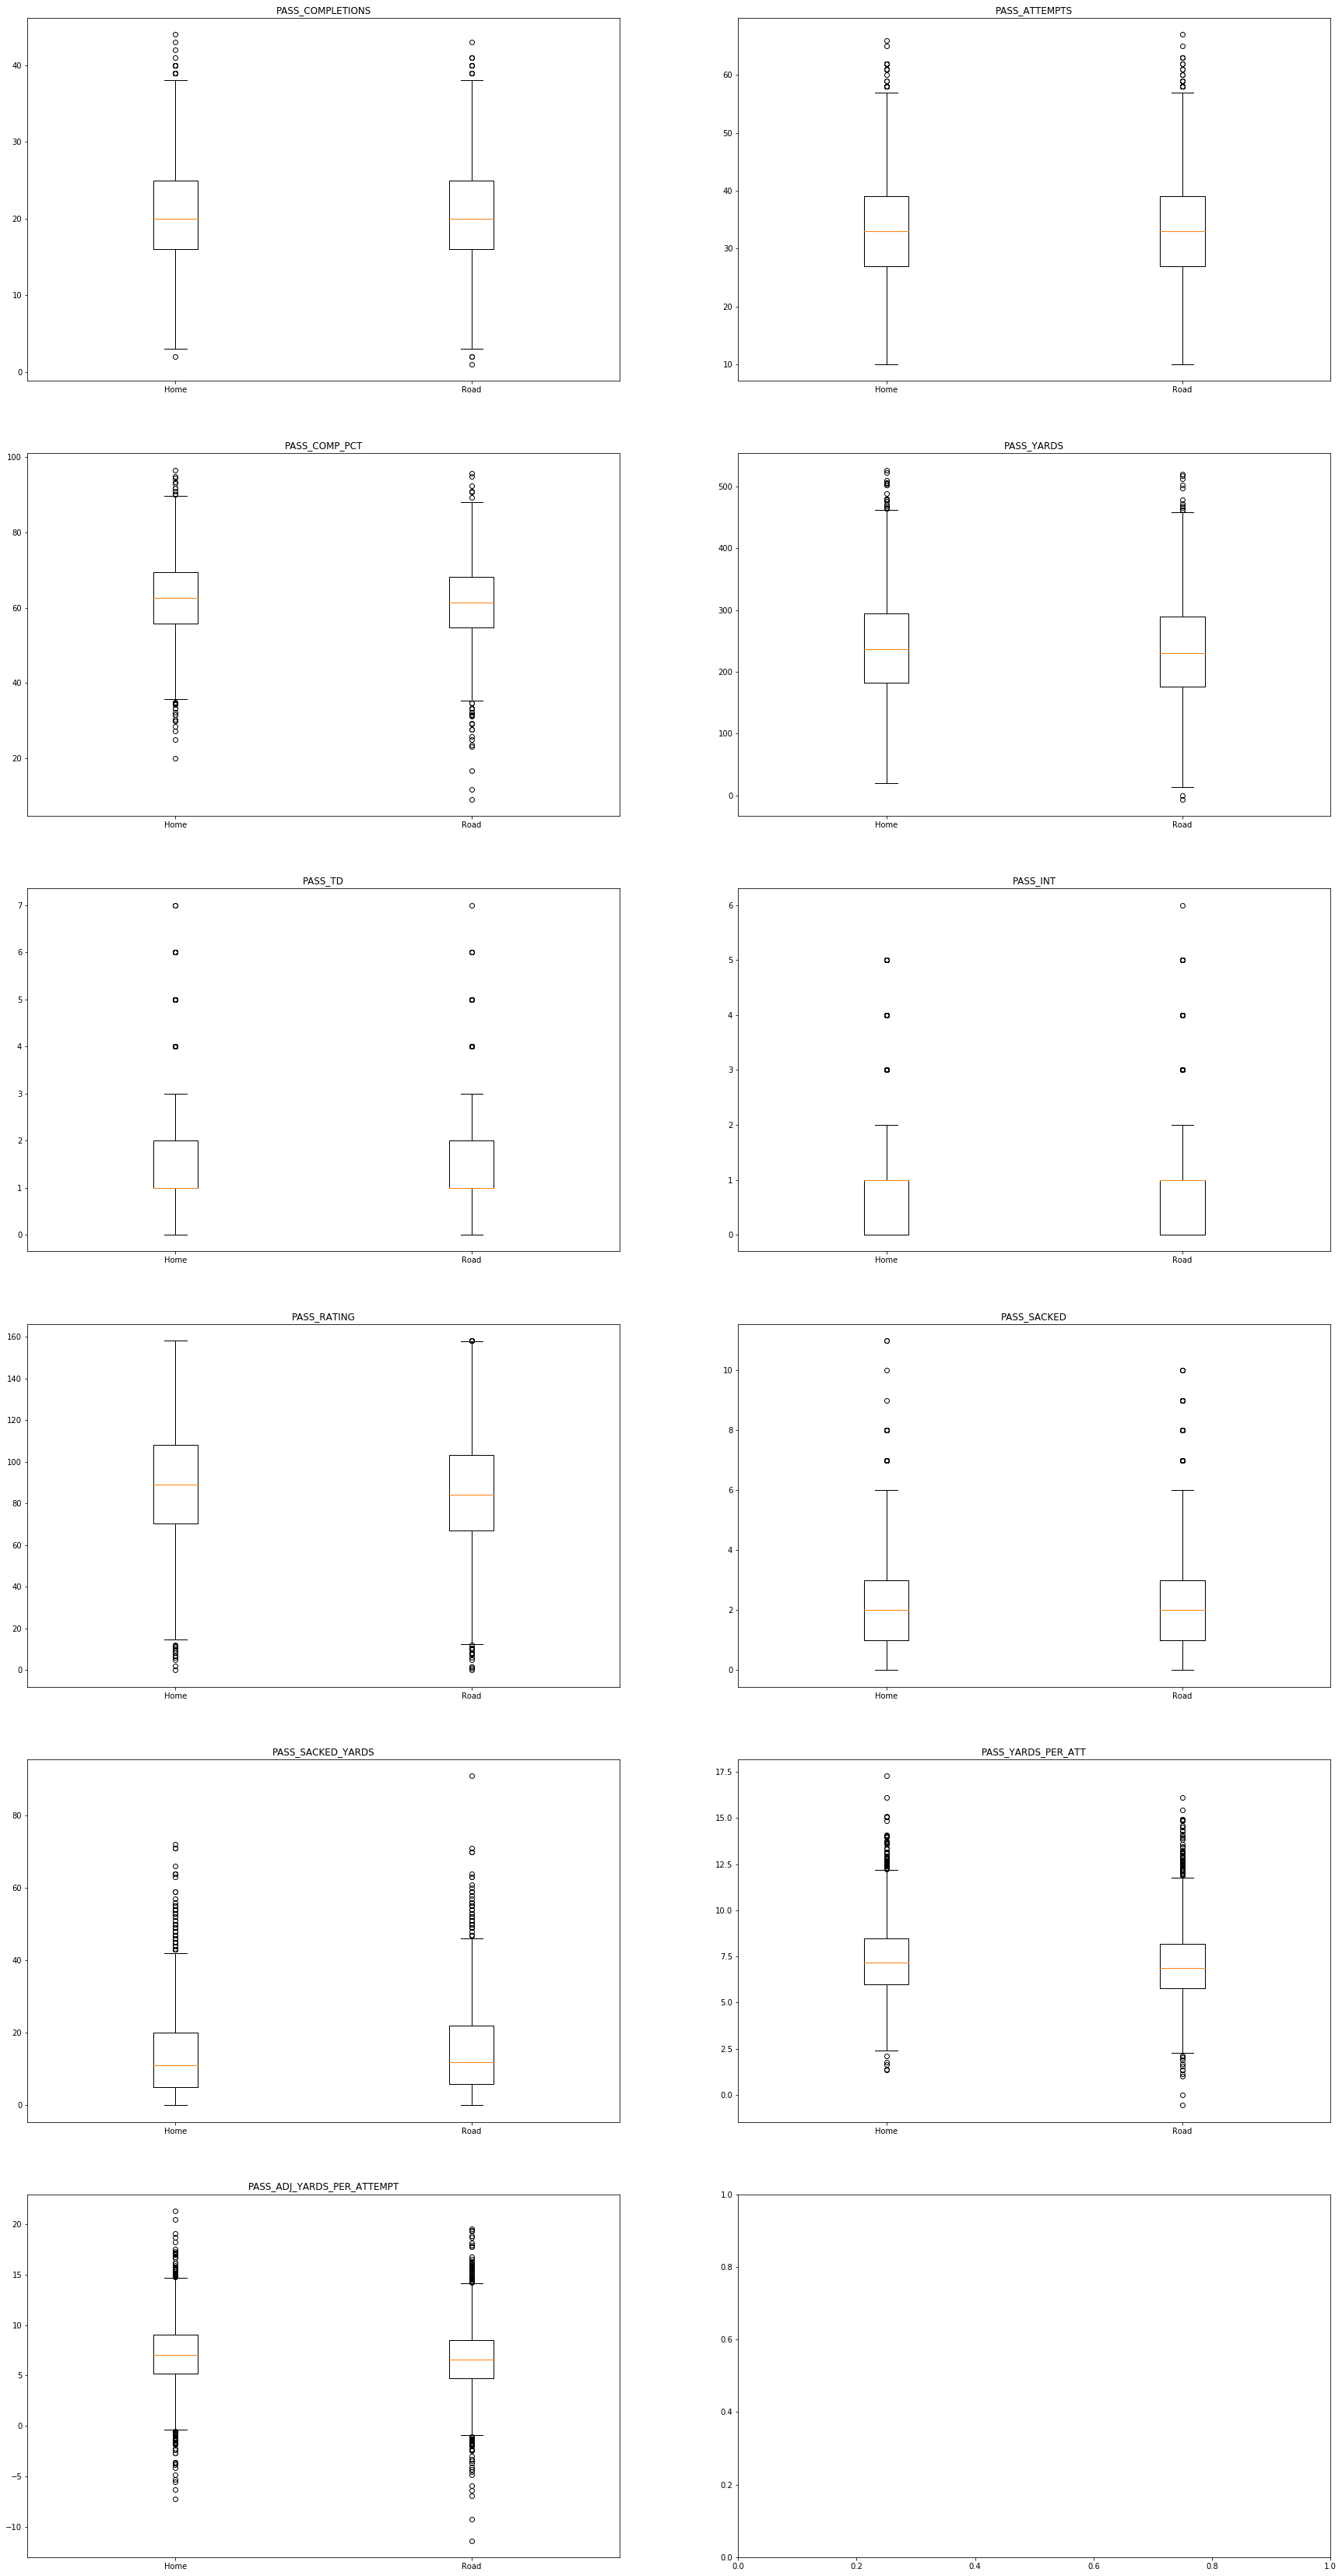

In [102]:
fig, axs = plt.subplots(nrows=6, ncols=2)
fig.set_size_inches(30, 60)
for col, ax in zip(home_games_stats.columns, chain(*axs)):
    ax.boxplot(x=[home_games[col], road_games[col]], labels=['Home', 'Road'])
    ax.set_title(col)

In [111]:
def get_val_dist_stats(home_games, road_games, stat_id_list):
    value_distribution_stats = {}
    for stat_id in stat_id_list:
        value_dist = get_value_distributions(road_games, home_games, stat_id)
        if type(value_dist['home_values'][0]) == str:
            continue
        value_distribution_stats[stat_id] = get_value_distribution_stats(value_dist, stat_id)
    return value_distribution_stats

In [51]:
def get_bins(home_games, road_games, col, num_bins=20):
    max_val = max([max(home_games[col]), max(road_games[col])])
    min_val = min(min(home_games[col].unique()), min(road_games[col].unique()))
    max_val = max(max(home_games[col].unique()), max(road_games[col].unique()))
    if len(home_games[col].unique()) < num_bins or len(road_games[col].unique()) < num_bins:
        return range(min_val, max_val)
    bins = np.linspace(0, max_val, num=num_bins)
    return bins

In [92]:
def get_hist_text(val_dist):
    s = 'Home Mean: ' + '{0:.2f}'.format(val_dist['home_mean']) + ' (n=' + str(val_dist['home_count']) + ')\n'
    s += 'Road Mean: ' + '{0:.2f}'.format(val_dist['road_mean']) + ' (n=' + str(val_dist['road_count']) + ')\n'
    s += 'Diff: ' + '{0:.2f}'.format(val_dist['difference']) + '\n'
    s += 'P Val: ' + '{0:.2f}'.format(val_dist['p_val']) + '\n'
    return s

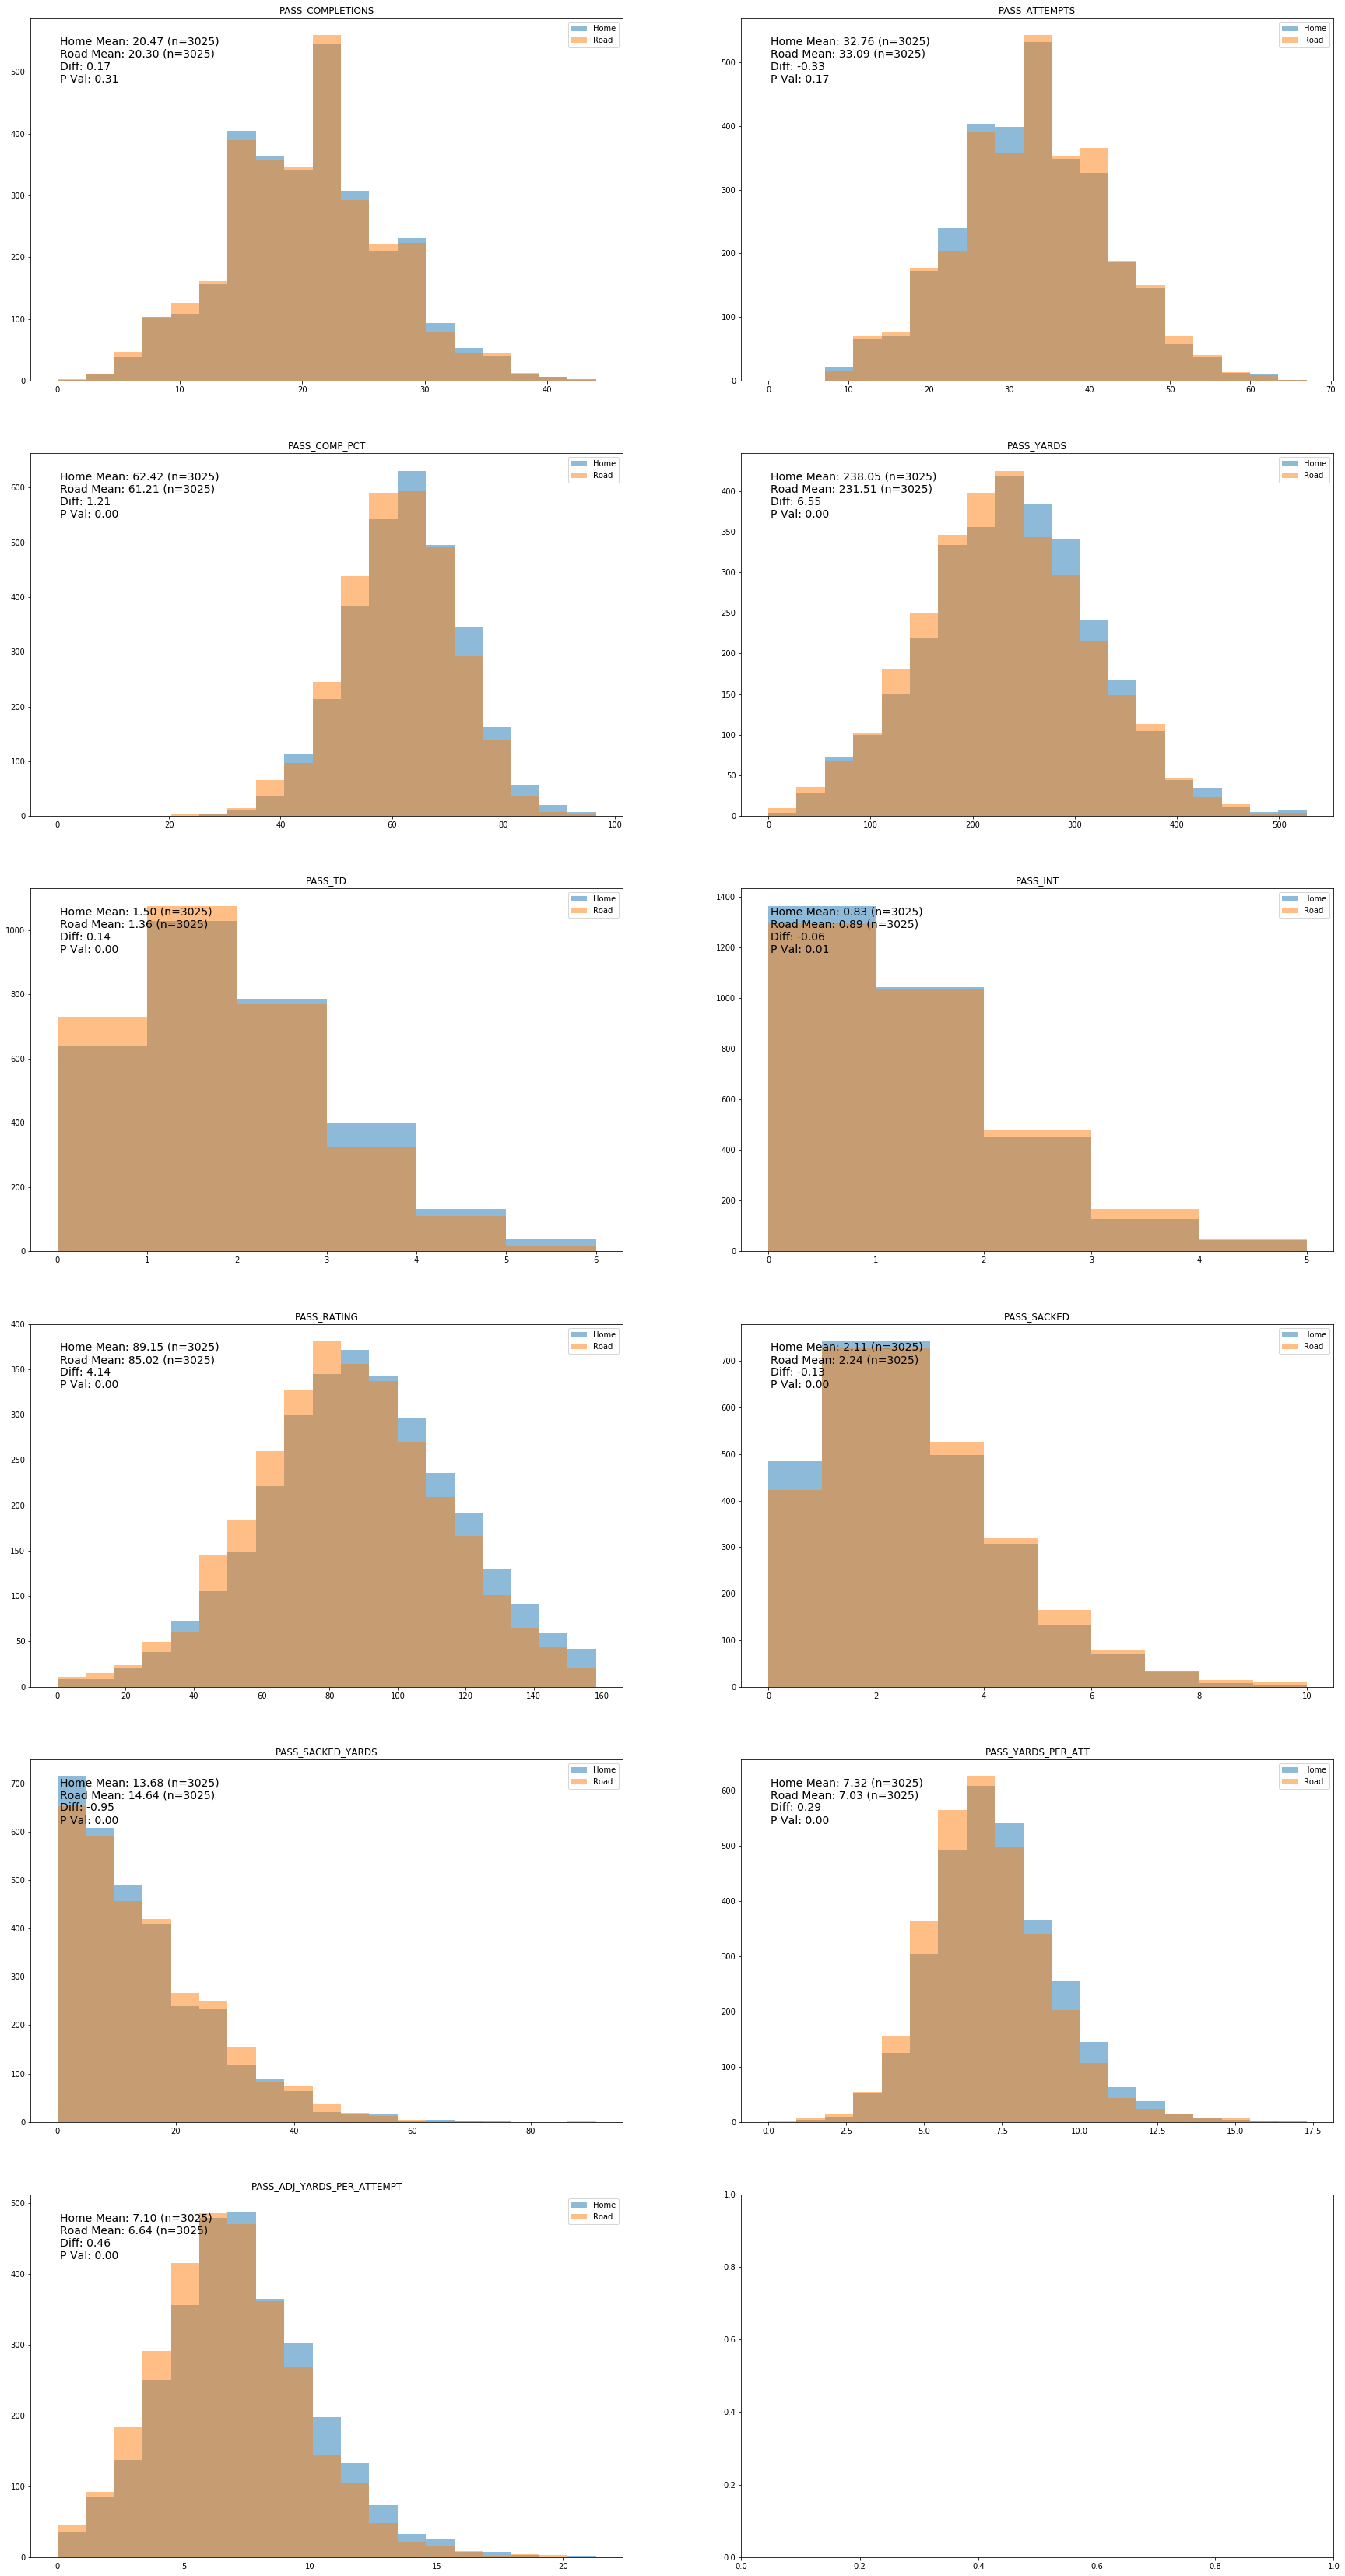

In [113]:
fig, axs = plt.subplots(nrows=6, ncols=2)
fig.set_size_inches(30, 60)
home_hist_vals = {}
road_hist_vals = {}
id2col = id_2_col()
passing_stat_id_list = list(map(lambda x: id2col[x], get_passing_stat_ids()))
value_distribution_stats = get_val_dist_stats(home_games, road_games, passing_stat_id_list)
for col, ax in zip(home_games_stats.columns, chain(*axs)):
    bins = get_bins(home_games, road_games, col)
    home_n, home_bins, home_patches = ax.hist(home_games[col], label='Home', alpha=0.5, bins=bins)
    road_n, road_bins, road_patches = ax.hist(road_games[col], label='Road', alpha=0.5, bins=bins)
    home_hist_vals[col] = { 'n': home_n, 'bins': home_bins, 'patches': home_patches }
    road_hist_vals[col] = { 'n': road_n, 'bins': road_bins, 'patches': road_patches }
    ax.legend(loc='upper right')
    ax.text(0.05, 0.95, get_hist_text(value_distribution_stats[col]), transform=ax.transAxes, fontsize=14,
        verticalalignment='top')
    ax.set_title(col)

In [155]:
passing_ids = list(map(lambda x: id2col[x], get_passing_stat_ids()))
value_distribution_stats = get_val_dist_stats(home_games, road_games, passing_ids)

In [156]:
road_games['PASS_RATING'].mean()

85.01646280991747

In [157]:
home_games['PASS_RATING'].mean()

89.15206611570243

In [158]:
home_games['POSITION'].unique()

array(['QB', 'WR'], dtype=object)

In [159]:
value_distribution_stats

{'PASS_ADJ_YARDS_PER_ATTEMPT': {'cohen': 0.1480195659499137,
  'difference': 0.4620297520661163,
  'home_count': 3025,
  'home_mean': 7.101900826446281,
  'home_std': 3.149685508123305,
  'my_t': 5.7556585512736325,
  'p_val': 9.05389814348271e-09,
  'road_count': 3025,
  'road_mean': 6.6398710743801646,
  'road_std': 3.092875986468857,
  'stat_type': 'passing',
  't_stat': 5.7556585512736325},
 'PASS_ATTEMPTS': {'cohen': -0.03534762210568131,
  'difference': -0.33223140495867653,
  'home_count': 3025,
  'home_mean': 32.75603305785124,
  'home_std': 9.319276253186441,
  'my_t': -1.3744726390333815,
  'p_val': 0.1693459238507788,
  'road_count': 3025,
  'road_mean': 33.08826446280992,
  'road_std': 9.478002952263585,
  'stat_type': 'passing',
  't_stat': -1.3744726390333815},
 'PASS_COMPLETIONS': {'cohen': 0.026128961623856646,
  'difference': 0.17289256198347402,
  'home_count': 3025,
  'home_mean': 20.47404958677686,
  'home_std': 6.597475422307716,
  'my_t': 1.0160101500171894,
  'p_

In [116]:
home_games.shape

(3025, 25)

In [117]:
home_games['YEAR'].unique()

array([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])

In [145]:
pr_stats = get_stats(home_games, road_games, 'PASS_RATING')

In [146]:
pr_stats

(5.795986228099683,
 7.134701962650293e-09,
 0.14905668188831567,
 5.795986228099446)